In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

cleaned_file_path = '../data/household_power_consumption_cleaned.csv'
df_cleaned = pd.read_csv(cleaned_file_path, index_col='DateTime', parse_dates=True)

agg_rules = {
    'Global_active_power': 'sum',
    'Global_reactive_power': 'sum',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
}
df_hourly = df_cleaned.resample('H').agg(agg_rules)

print("Годинні дані успішно завантажено. Розмір:", df_hourly.shape)
df_hourly.head()

Годинні дані успішно завантажено. Розмір: (34560, 7)


/var/folders/qx/qcg8gq_95sj0ckv67r12b2yw0000gn/T/ipykernel_29021/3599176181.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_cleaned.resample('H').agg(agg_rules)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-17 10:00:00,166.352,10.264,234.446486,19.275676,533.0,1341.0,623.0
2006-12-17 11:00:00,105.120,6.248,235.731622,12.140541,567.0,296.0,630.0
2006-12-17 12:00:00,0.000,0.000,NaN,NaN,0.0,0.0,0.0
2006-12-17 13:00:00,0.000,0.000,NaN,NaN,0.0,0.0,0.0
2006-12-17 14:00:00,0.000,0.000,NaN,NaN,0.0,0.0,0.0


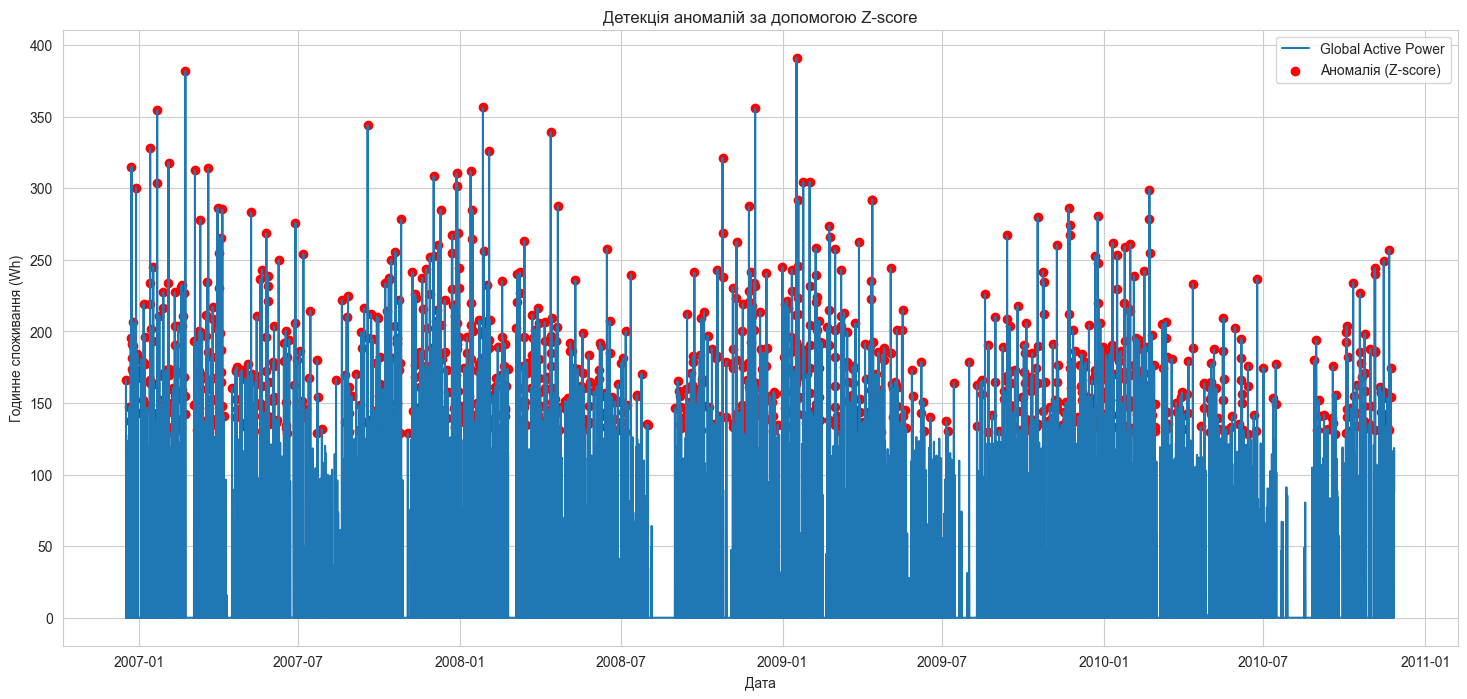

Знайдено 1137 аномалій за методом Z-score.


In [2]:
data_column = df_hourly['Global_active_power']

mean_val = data_column.mean()
std_val = data_column.std()

# Встановлюємо поріг (3 стандартних відхилення)
z_score_threshold = 3

# Знаходимо аномалії
is_anomaly_zscore = (np.abs(data_column - mean_val) / std_val) > z_score_threshold

# Візуалізація
plt.plot(data_column.index, data_column, label='Global Active Power')
plt.scatter(data_column.index[is_anomaly_zscore], data_column[is_anomaly_zscore], color='red', label='Аномалія (Z-score)')
plt.title('Детекція аномалій за допомогою Z-score')
plt.xlabel('Дата')
plt.ylabel('Годинне споживання (Wh)')
plt.legend()
plt.show()

print(f"Знайдено {np.sum(is_anomaly_zscore)} аномалій за методом Z-score.")

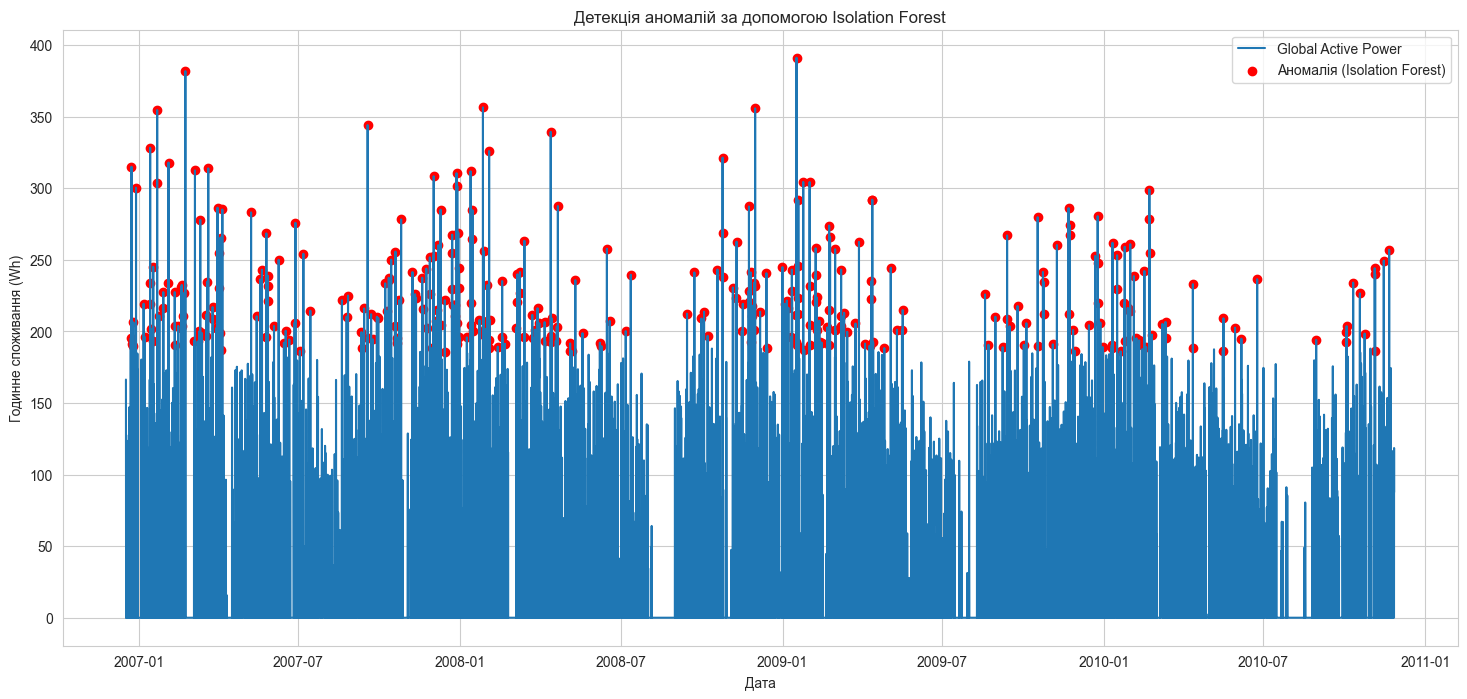

Знайдено 343 аномалій за методом Isolation Forest.


In [3]:
# Створюємо модель Isolation Forest
# 'contamination' - це очікувана частка аномалій у даних (напр., 1%)
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Навчаємо модель. reshape(-1, 1) потрібен, бо модель очікує 2D-масив
predictions = iso_forest.fit_predict(df_hourly[['Global_active_power']])

# Результат: -1 для аномалій, 1 для нормальних даних
is_anomaly_isoforest = predictions == -1

# Візуалізація
plt.plot(df_hourly.index, df_hourly['Global_active_power'], label='Global Active Power')
plt.scatter(df_hourly.index[is_anomaly_isoforest], df_hourly['Global_active_power'][is_anomaly_isoforest], color='red', label='Аномалія (Isolation Forest)')
plt.title('Детекція аномалій за допомогою Isolation Forest')
plt.xlabel('Дата')
plt.ylabel('Годинне споживання (Wh)')
plt.legend()
plt.show()

print(f"Знайдено {np.sum(is_anomaly_isoforest)} аномалій за методом Isolation Forest.")

In [4]:
# Додаємо новий бінарний стовпець до нашого DataFrame
# 1 - якщо це аномалія, 0 - якщо ні
df_hourly['is_anomaly'] = is_anomaly_isoforest.astype(int)

# Подивимось на рядки, де були знайдені аномалії
print("Приклади рядків, позначених як аномалії:")
display(df_hourly[df_hourly['is_anomaly'] == 1].head())

# Подивимось на фінальний DataFrame з новою ознакою
print("\nПерші 5 рядків DataFrame з новою ознакою 'is_anomaly':")
display(df_hourly.head())

# Тепер можна зберегти цей DataFrame для подальшого використання
df_hourly.to_csv('../data/household_power_consumption_hourly_with_anomalies.csv')
print("\nDataFrame з ознакою аномалій збережено.")

Приклади рядків, позначених як аномалії:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_anomaly
DateTime,,,,,,,,
2006-12-22 21:00:00,195.326,3.120,234.932857,19.919048,551.0,0.0,710.0,1
2006-12-23 17:00:00,315.030,12.360,233.572105,23.670175,971.0,37.0,955.0,1
2006-12-23 23:00:00,191.250,3.662,239.627187,25.025000,756.0,0.0,508.0,1
2006-12-25 16:00:00,190.034,19.848,241.333617,16.982979,1645.0,0.0,0.0,1
2006-12-25 22:00:00,206.296,3.474,236.645000,19.818182,550.0,87.0,341.0,1



Перші 5 рядків DataFrame з новою ознакою 'is_anomaly':


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_anomaly
DateTime,,,,,,,,
2006-12-17 10:00:00,166.352,10.264,234.446486,19.275676,533.0,1341.0,623.0,0
2006-12-17 11:00:00,105.120,6.248,235.731622,12.140541,567.0,296.0,630.0,0
2006-12-17 12:00:00,0.000,0.000,NaN,NaN,0.0,0.0,0.0,0
2006-12-17 13:00:00,0.000,0.000,NaN,NaN,0.0,0.0,0.0,0
2006-12-17 14:00:00,0.000,0.000,NaN,NaN,0.0,0.0,0.0,0



DataFrame з ознакою аномалій збережено.
